In [1]:
import numpy as np  # to handle matrix
import pandas as pd # to handle data
from matplotlib import pyplot as plt # to visualize
import datetime, pytz # to handle time
from sklearn.model_selection import train_test_split # Split data
from sklearn.ensemble import RandomForestRegressor # Random Forest Classifier

In [2]:
df = pd.read_csv('ETH-USD (2017-2024)_2.csv')

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,USD_Volume
0,11/10/2017,320.670990,324.717987,294.541992,299.252991,299.252991,8.859860e+08,265133955696.08
1,11/11/2017,298.585999,319.453003,298.191986,314.681000,314.681000,8.423010e+08,265056118463.55
2,11/12/2017,314.690002,319.153015,298.513000,307.907990,307.907990,1.613480e+09,496803363999.09
3,11/13/2017,307.024994,328.415009,307.024994,316.716003,316.716003,1.041890e+09,329983231298.21
4,11/14/2017,316.763000,340.177002,316.763000,337.631012,337.631012,1.069680e+09,361157140916.16


In [3]:
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

In [5]:
# First thing is to fix the data for bars/candles where there are no trades. 
# Volume/trades are a single event so fill "NaN"s with zeroes for relevant fields...
df['Volume'].fillna(value=0, inplace=True)
df['USD_Volume'].fillna(value=0, inplace=True)
df['Adj Close'].fillna(value=0, inplace=True)

# Secondly, we need to fix the OHLC (open, high, low, close) data which is a continuous timeseries so
# let's fill forwards those values.
df['Open'].fillna(method='ffill', inplace=True)
df['High'].fillna(method='ffill', inplace=True)
df['Low'].fillna(method='ffill', inplace=True)
df['Close'].fillna(method='ffill', inplace=True)

df.tail()

C:\Users\maggi\AppData\Local\Temp\ipykernel_9652\2564119915.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Volume'].fillna(value=0, inplace=True)
C:\Users\maggi\AppData\Local\Temp\ipykernel_9652\2564119915.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, wh

,Date,Open,High,Low,Close,Adj Close,Volume,USD_Volume
2259,2024-01-17,2587.044678,2592.737061,2508.432861,2528.369385,2528.369385,1.044102e+10,26398749045816.60
2260,2024-01-18,2528.593262,2546.263916,2426.135498,2467.018799,2467.018799,1.190003e+10,29357592981987.90
2261,2024-01-19,2468.688965,2501.305176,2414.710938,2489.498535,2489.498535,1.140528e+10,28393423808319.20
2262,2024-01-20,2468.688965,2501.305176,2414.710938,2489.498535,0.000000,0.000000e+00,#VALUE!
2263,2024-01-21,2469.798584,2469.798584,2464.171875,2465.659180,2465.659180,5.195812e+09,12811102423266.20


In [6]:
start = df['Date'].min()
end = '2024-01-19'

# find rows between start and end time and find the first row (00:00 monday morning)
# Grouping by day
daily_df = df[(df['Date'] >= start) & (df['Date'] <= end)].groupby([pd.Grouper(key='Date', freq='D')]).first().reset_index()
daily_df = daily_df.set_index('Date')
daily_df.tail(3)

,Open,High,Low,Close,Adj Close,Volume,USD_Volume
Date,,,,,,,
2024-01-17,2587.044678,2592.737061,2508.432861,2528.369385,2528.369385,1.044102e+10,26398749045816.60
2024-01-18,2528.593262,2546.263916,2426.135498,2467.018799,2467.018799,1.190003e+10,29357592981987.90
2024-01-19,2468.688965,2501.305176,2414.710938,2489.498535,2489.498535,1.140528e+10,28393423808319.20


In [8]:
historical_df = daily_df
for i in range(1,8): # for 7 days
    historical_df["Open_e_"+str(i)] = daily_df['Open'].shift(i)
    historical_df["High_e_"+str(i)] = daily_df['High'].shift(i)
    historical_df["Low_e_"+str(i)]  = daily_df['Low'].shift(i)
    historical_df["Close_e_"+str(i)]= daily_df['Close'].shift(i)
    historical_df["Volume_e_"+str(i)]      = daily_df['Volume'].shift(i)
    historical_df["USD_Volume_e_"+str(i)] = daily_df['USD_Volume'].shift(i)

historical_df = historical_df.dropna() # drop the first rows. They don't have previous information 
print("Historical Data Shape: ", historical_df.shape)
historical_df.tail(3)

Historical Data Shape:  (2255, 49)


,Open,High,Low,Close,Adj Close,Volume,USD_Volume,Open_e_1,High_e_1,Low_e_1,...,Low_e_6,Close_e_6,Volume_e_6,USD_Volume_e_6,Open_e_7,High_e_7,Low_e_7,Close_e_7,Volume_e_7,USD_Volume_e_7
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-17,2587.044678,2592.737061,2508.432861,2528.369385,2528.369385,1.044102e+10,26398749045816.60,2510.627197,2613.566895,2500.003906,...,2567.993652,2619.619141,2.257525e+10,59138548847507.40,2344.923584,2626.976807,2341.943115,2582.103516,2.904210e+10,74989709751104.90
2024-01-18,2528.593262,2546.263916,2426.135498,2467.018799,2467.018799,1.190003e+10,29357592981987.90,2587.044678,2592.737061,2508.432861,...,2460.925537,2524.460205,2.362384e+10,59637442108760.00,2584.171631,2687.779053,2567.993652,2619.619141,2.257525e+10,59138548847507.40
2024-01-19,2468.688965,2501.305176,2414.710938,2489.498535,2489.498535,1.140528e+10,28393423808319.20,2528.593262,2546.263916,2426.135498,...,2498.594482,2576.597900,1.225032e+10,31564140713846.80,2619.177002,2710.421875,2460.925537,2524.460205,2.362384e+10,59637442108760.00


In [9]:
historical_df["NEXT_CLOSE"] = historical_df['Close'].shift(-1) # Add next data as a label for current data
historical_df = historical_df.dropna() # drop the last row. It doesn't have next information 
print("after adding next CLOSE Label, new shape:", historical_df.shape)
historical_df.tail(3)

after adding next CLOSE Label, new shape: (2254, 50)


C:\Users\maggi\AppData\Local\Temp\ipykernel_9652\2295155591.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historical_df["NEXT_CLOSE"] = historical_df['Close'].shift(-1) # Add next data as a label for current data


,Open,High,Low,Close,Adj Close,Volume,USD_Volume,Open_e_1,High_e_1,Low_e_1,...,Close_e_6,Volume_e_6,USD_Volume_e_6,Open_e_7,High_e_7,Low_e_7,Close_e_7,Volume_e_7,USD_Volume_e_7,NEXT_CLOSE
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-16,2510.627197,2613.566895,2500.003906,2587.691162,2587.691162,1.106332e+10,28628447869135.00,2471.666992,2550.769043,2470.820801,...,2582.103516,2.904210e+10,74989709751104.90,2332.868164,2369.641602,2243.219238,2344.827148,1.489113e+10,34917127567293.50,2528.369385
2024-01-17,2587.044678,2592.737061,2508.432861,2528.369385,2528.369385,1.044102e+10,26398749045816.60,2510.627197,2613.566895,2500.003906,...,2619.619141,2.257525e+10,59138548847507.40,2344.923584,2626.976807,2341.943115,2582.103516,2.904210e+10,74989709751104.90,2467.018799
2024-01-18,2528.593262,2546.263916,2426.135498,2467.018799,2467.018799,1.190003e+10,29357592981987.90,2587.044678,2592.737061,2508.432861,...,2524.460205,2.362384e+10,59637442108760.00,2584.171631,2687.779053,2567.993652,2619.619141,2.257525e+10,59138548847507.40,2489.498535


In [10]:
# split data
prediction_days = 140
df_train = historical_df[:len(historical_df) - prediction_days ]
df_test  = historical_df[ len(historical_df) - prediction_days:]

print("PERCENT test/total data = %", (prediction_days/len(historical_df)) * 100)
print("train data shape:", df_train.shape)
print("test data shape:", df_test.shape)

training_set = df_train.values
X_train = training_set[0:len(training_set), 0:49]
y_train = training_set[0:len(training_set), 49].reshape(-1,1)

test_set = df_test.values
X_test = test_set[0:len(test_set), 0:49]
y_test = test_set[0:len(test_set), 49].reshape(-1,1)

df_train.head(3)

PERCENT test/total data = % 6.211180124223603
train data shape: (2114, 50)
test data shape: (140, 50)


,Open,High,Low,Close,Adj Close,Volume,USD_Volume,Open_e_1,High_e_1,Low_e_1,...,Close_e_6,Volume_e_6,USD_Volume_e_6,Open_e_7,High_e_7,Low_e_7,Close_e_7,Volume_e_7,USD_Volume_e_7,NEXT_CLOSE
Date,,,,,,,,,,,,,,,,,,,,,
2017-11-17,330.166992,334.963989,327.523010,332.394012,332.394012,6.217330e+08,206660323603.64,333.442993,336.158997,323.605988,...,314.681000,8.423010e+08,265056118463.55,320.670990,324.717987,294.541992,299.252991,8.859860e+08,265133955696.08,347.612000
2017-11-18,331.980011,349.615997,327.687012,347.612000,347.612000,6.496390e+08,225822303725.31,330.166992,334.963989,327.523010,...,307.907990,1.613480e+09,496803363999.09,298.585999,319.453003,298.191986,314.681000,8.423010e+08,265056118463.55,354.385986
2017-11-19,347.401001,371.290985,344.739990,354.385986,354.385986,1.181530e+09,418717668368.40,331.980011,349.615997,327.687012,...,316.716003,1.041890e+09,329983231298.21,314.690002,319.153015,298.513000,307.907990,1.613480e+09,496803363999.09,366.730011


In [11]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 5)
rf.fit(X_train, np.ravel(y_train));
predictions = rf.predict(X_test)
# Calculate the absolute errors
errors = np.sqrt(np.mean(np.square(predictions.reshape(-1,1) - y_test.reshape(-1,1) )))
# Print out the root mean square error (rmse)
print('RMSE:', errors)
print('R^2 Score - Coefficient of Determination', rf.score(X_test, y_test))

RMSE: 60.944637253135646
R^2 Score - Coefficient of Determination 0.9627833456679227


In [12]:
df_Result = pd.DataFrame(y_test, index=df_test.index, columns=["NEXT_CLOSE"])
df_Result['Predicted'] = predictions
df_Result = df_Result.sort_values('Date')
df_Result.tail(3)

,NEXT_CLOSE,Predicted
Date,,
2024-01-16,2528.369385,2621.899332
2024-01-17,2467.018799,2605.803660
2024-01-18,2489.498535,2580.434989


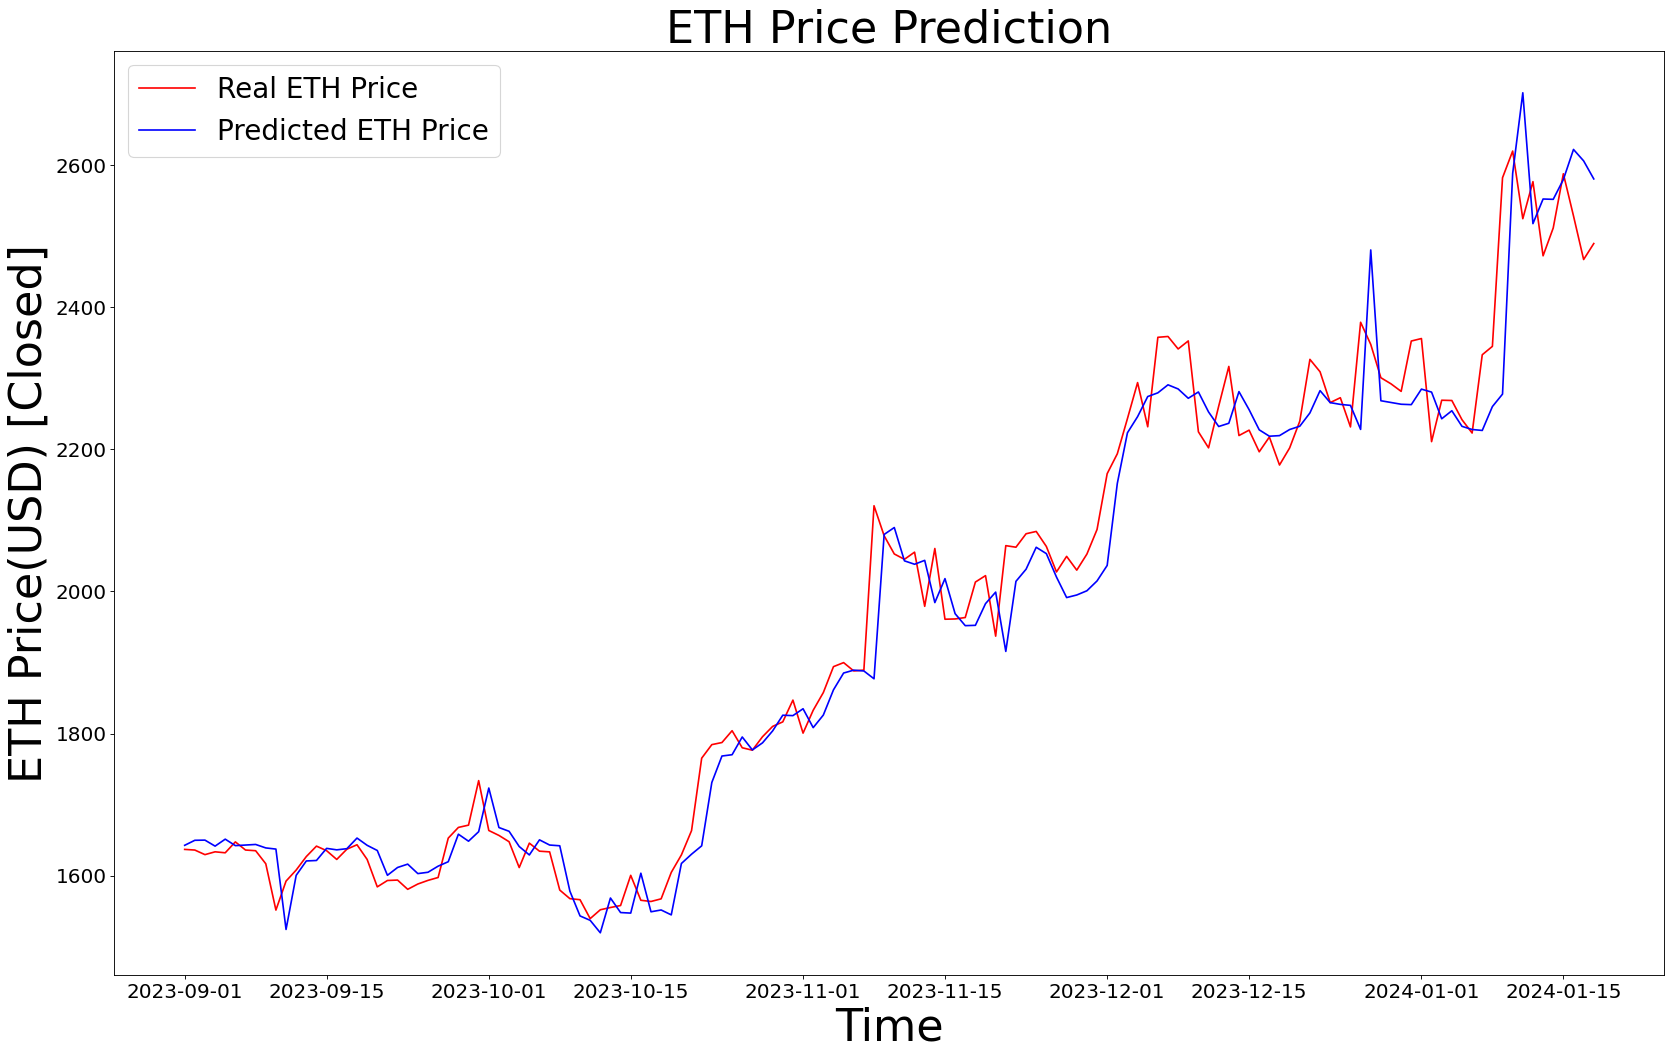

In [14]:
# Visualising the results
plt.figure(figsize=(25,15), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()  
plt.plot(df_Result['NEXT_CLOSE'], color = 'red', label = 'Real ETH Price')
plt.plot(df_Result['Predicted'], color = 'blue', label = 'Predicted ETH Price')
plt.title('ETH Price Prediction', fontsize=40)
df_test = df_Result.reset_index()
x = df_test.index
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
plt.xlabel('Time', fontsize=40)
plt.ylabel('ETH Price(USD) [Closed]', fontsize=40)
plt.legend(loc=2, prop={'size': 25})
plt.show()